In [175]:
import os
import pandas
from IPython.display import Image

Hi Hani,

I have just sent you the Box folder for our fastq files. We have 6 different conditions here with triplicates:
- KO-C (KO control)
- KO-T (KO treated)
- AD-C (addback control)
- AD-T (addback treated)
- pMXS_T (KO tumors)
- ATG7_T (addback tumors)

Our initial analysis gave us a really weird volcano plot as attached and we were not sure what the problem was.
It will be great if you can help us re-analyse. These are mouse cells so the alignment should be to mouse.

For the differential comparisons, we would like to compare:
- AD-C vs AD-T
- AD-C vs KO-C
- AD-T vs KO-T
- AD-C vs ATG7_T
- ATG7_T vs pMXS_T

Let me know if you need any other information. Thank you so much for your help.

In [ ]:
%%bash
ls fastq/*.fastq.gz

### Trimming task

In [ ]:
if not os.path.exists('./qc_fastq'):
    os.mkdir('qc_fastq')

In [ ]:
%%bash
# fastq QC 
for f in fastq/*.fastq.gz; do
    fastqc -f fastq --noextract -t 12 -o qc_fastq/ ./$f;
done

In [ ]:
# %%bash
# # Trimming task
# for f in *.fastq.gz; do
#     out=${f/R1_001.fastq.gz/trim.fastq.gz};     
#     echo cutadapt -u 3 -j 12 -q 15 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -o $out $f;
# done

In [ ]:
# %%bash
# ls *trim*

### Alignment task

human... also look at HIV genome

In [ ]:
if not os.path.exists('./bam'):
    os.mkdir('bam')

In [ ]:
%%bash
for f in fastq/*fastq.gz; do
    echo $f;
    out=${f/_R1_001.fastq.gz/_};
    out=${out/fastq/bam};
    STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 8 --sjdbGTFfile /rumi/shams/genomes/mm10/mm10_ensemble_genes.gtf --genomeDir /rumi/shams/genomes/mm10 --readFilesIn $f --outFileNamePrefix $out;
done&

### Measure counts

In [ ]:
if not os.path.exists('./feature_counts'):
    os.mkdir('feature_counts')

In [ ]:
%%bash
for f in bam/*.out.bam; do
    out=${f/_S*/.gene.fc};
    out=${out/bam/feature_counts};
    featureCounts -T 12 -P -B -C -O -t exon -g gene_id -a /rumi/shams/genomes/mm10/mm10_ensemble_genes.gtf -o $out $f;
done&

### Models
1. AD-C vs AD-T
2. AD-C vs KO-C
3. AD-T vs KO-T
4. AD-C vs ATG7_T
5. ATG7_T vs pMXS_T

In [ ]:
if not os.path.exists('./results'):
    os.mkdir('results')
if not os.path.exists('./results/plots'):
    os.mkdir('results/plots')

Move to R:

In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(DESeq2,quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(gridExtra, quietly = TRUE)
library(NOISeq, quietly = TRUE)
# library(ggrepel, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
# library(ggpubr, quietly = TRUE)
# library(org.Mm.eg.db,quietly = TRUE)
# library(annotate,quietly = TRUE)
library(dplyr)


In [142]:
%%R
# meta data
sample.type <- c(rep("AD",6), rep("ATG7",3), rep("KO",6), rep("pMXS",3))
sample.cond <- c(rep('C',3), rep('T',3), rep('T',3), rep('C',3), rep('T',3), rep('T',3))
replicate <- c(rep(c('1','2','3'),6))
all_cond <- paste(sample.type, paste (sample.cond, replicate, sep=""), sep="_")
conds <- paste(sample.type, sample.cond, sep="_")
# models 
model_1 = c("AD_C", "AD_T")
model_2 = c("AD_C", "KO_C")
model_3 = c("AD_T", "KO_T")
model_4 = c("AD_C", "ATG7_T")
model_5 = c("ATG7_T", "pMXS_T")
## read count files 
files <- list.files(path="feature_counts" , pattern=".fc$")
datalist <- lapply(files, function(x){read.table(file=paste('feature_counts/',x, sep = ''),header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
# set gene names 
mm10 <- ensemblGenome()
read.gtf(mm10, '/rumi/shams/genomes/mm10/mm10_ensemble_genes.gtf', useBasedir = F)
mm10 <- getGenePositions(mm10)
df <- data.frame('gene_name' = mm10$gene_name, row.names = mm10$gene_id, stringsAsFactors=FALSE)
rownames(m) <- make.unique(list(df[m[,1],])[[1]])
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- all_cond

[read.gtf.refGenome] Reading file 'mm10_ensemble_genes.gtf'.
[GTF]  1667354 lines processed.
[read.gtf.refGenome] Extracting genes table.
[read.gtf.refGenome] Found 49,585 gene records.
[read.gtf.refGenome] Finished.


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: Saving 6.67 x 6.67 in image



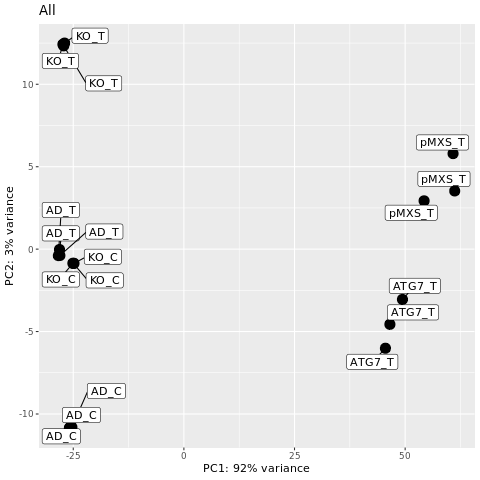

In [143]:
%%R
colData <- data.frame(conds, row.names=colnames(m))
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ conds)
dds <- DESeq(dds)
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)

## PCA Plot 
z <- plotPCA(vsd,intgroup=c("conds"), returnData=TRUE)
percentVar <- round(100 * attr(z, "percentVar"))
p <- ggplot(z, aes(PC1, PC2)) +
  geom_point(aes(size = 4)) +
  ggtitle('All') + 
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_label_repel(label = conds, force = 10) +
  guides(size = FALSE)
ggsave(paste('results/plots/All_PCA.png',sep=''), plot = p, device = 'png', dpi = 300)
print(p)

In [171]:
%%R
## PCA 2 genes
# https://rdrr.io/bioc/NOISeq/man/PCA.GENES.html
myPCA <- PCA.GENES(t(m))
print ('============================== PCA 2 top 20 genes ==============================')
print (head(sort(myPCA$loadings[,2], T), n = 20) )
print ('================================================================================')
print (summary(myPCA))

[1] "============================== PCA 2 top 20 genes =============================="
      Mir7031       Tmem116       Gm12787        Vax2os          Rpl6 
   0.47475238    0.42499987    0.22063417    0.19204904    0.15994452 
      Gm44480        Acad10       Gm16552        Gm2768 C130021I20Rik 
   0.14006282    0.13973314    0.11642228    0.09307647    0.08108264 
       Lrrc40       Gm12871       Gm13183       Fam109a          Eef2 
   0.07927616    0.07822446    0.07207600    0.07096792    0.06733429 
      Gm43839        Gm4222        Trafd1          Ppbp       Mir133b 
   0.06708733    0.06490782    0.06222860    0.05682088    0.05415250 
[1] "================================================================================"
         Length Class  Mode   
eigen         2 eigen  list   
var.exp      36 -none- numeric
scores      324 -none- numeric
loadings 892530 -none- numeric


In [173]:
%%R
for (i in c(1:5)){
    model = get(paste('model',i,sep='_'))
    model_name = paste(model[1], model[2], sep ='_VS_')
    samples <- rep('skip', length(conds))
    samples[which(conds == model[1])] <- 'sample_1'
    samples[which(conds == model[2])] <- 'sample_2'
    cond <- paste(sample.type[which(samples != 'skip')], sample.cond[which(samples != 'skip')], sep="_")

    mm <- m[,which(samples != 'skip')]

    colData <- data.frame(cond, row.names=colnames(mm))
    dds <- DESeqDataSetFromMatrix(countData = mm, colData = colData, design = ~ cond)
    dds$cond <- relevel(dds$cond, ref=model[1])
    dds <- DESeq(dds)
    cds <- estimateDispersions(dds)
    vsd <- varianceStabilizingTransformation(cds)
    
    # normalized counts 
    ncu <- counts(dds, normalized=TRUE)
    # Raw tabels 
    write.table(ncu, file=paste('results/model',i, model_name, "gene_count_table_DE2norm.txt", sep='_'), sep="\t", quote=FALSE, col.names=colnames(mm)) 
    write.table(mm, file=paste('results/model',i, model_name, "gene_count_table_raw.txt", sep='_'), sep="\t", quote=FALSE, col.names=colnames(mm))
    # model:
    res <- results(dds)
    write.table(res, paste('results/', paste('model',i, model_name, sep='_'), ".txt", sep=''), sep="\t", quote=FALSE, col.names=NA)
    
    ## PCA Plot 
    z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    p <- ggplot(z, aes(PC1, PC2)) +
      geom_point(aes(size = 4)) +
      ggtitle(paste('Model', i,':', model[1], 'vs', model[2])) + 
      xlab(paste0("PC1: ",percentVar[1],"% variance")) +
      ylab(paste0("PC2: ",percentVar[2],"% variance")) +
      geom_label_repel(label = cond, force = 10) +
      guides(size = FALSE)
    ggsave(paste('results/plots/model_',i,'_PCA.png',sep=''), plot = p, device = 'png', dpi = 300)

    ## Volcano plot 
    vol <- EnhancedVolcano(res,
        lab = rownames(res),
        x = 'log2FoldChange',
        y = 'pvalue',
        xlim = c(-6, 6),
        title = paste('Model', i),
        pCutoff = 10e-2,
        FCcutoff = 1.5)
    ggsave(paste('results/plots/model_',i,'_Volcano.png',sep=''), plot = vol, device = 'png', dpi = 300)
        
#     # Positive results 
#     res <- data.frame(res, row.names = rownames(res))
#     positive_res <- res %>% 
#                     rownames_to_column('gene') %>%
#                     filter(log2FoldChange > 0 & pvalue < 1e-3)
#     positive_ncu <- ncu[positive_res$gene,]

#     write.table(positive_res, file=paste('results/model',i, model_name, "positive.txt", sep='_'), sep="\t", quote=FALSE, col.names=NA )
#     write.table(positive_ncu, file=paste('results/model',i, model_name, "positive_gene_count_table_DE2norm.txt", sep='_'), sep="\t", quote=FALSE, col.names=colnames(mm)) 
#     # Print model results:
#     resultsNames(dds)
}

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fit

In [ ]:
%%R


# 1

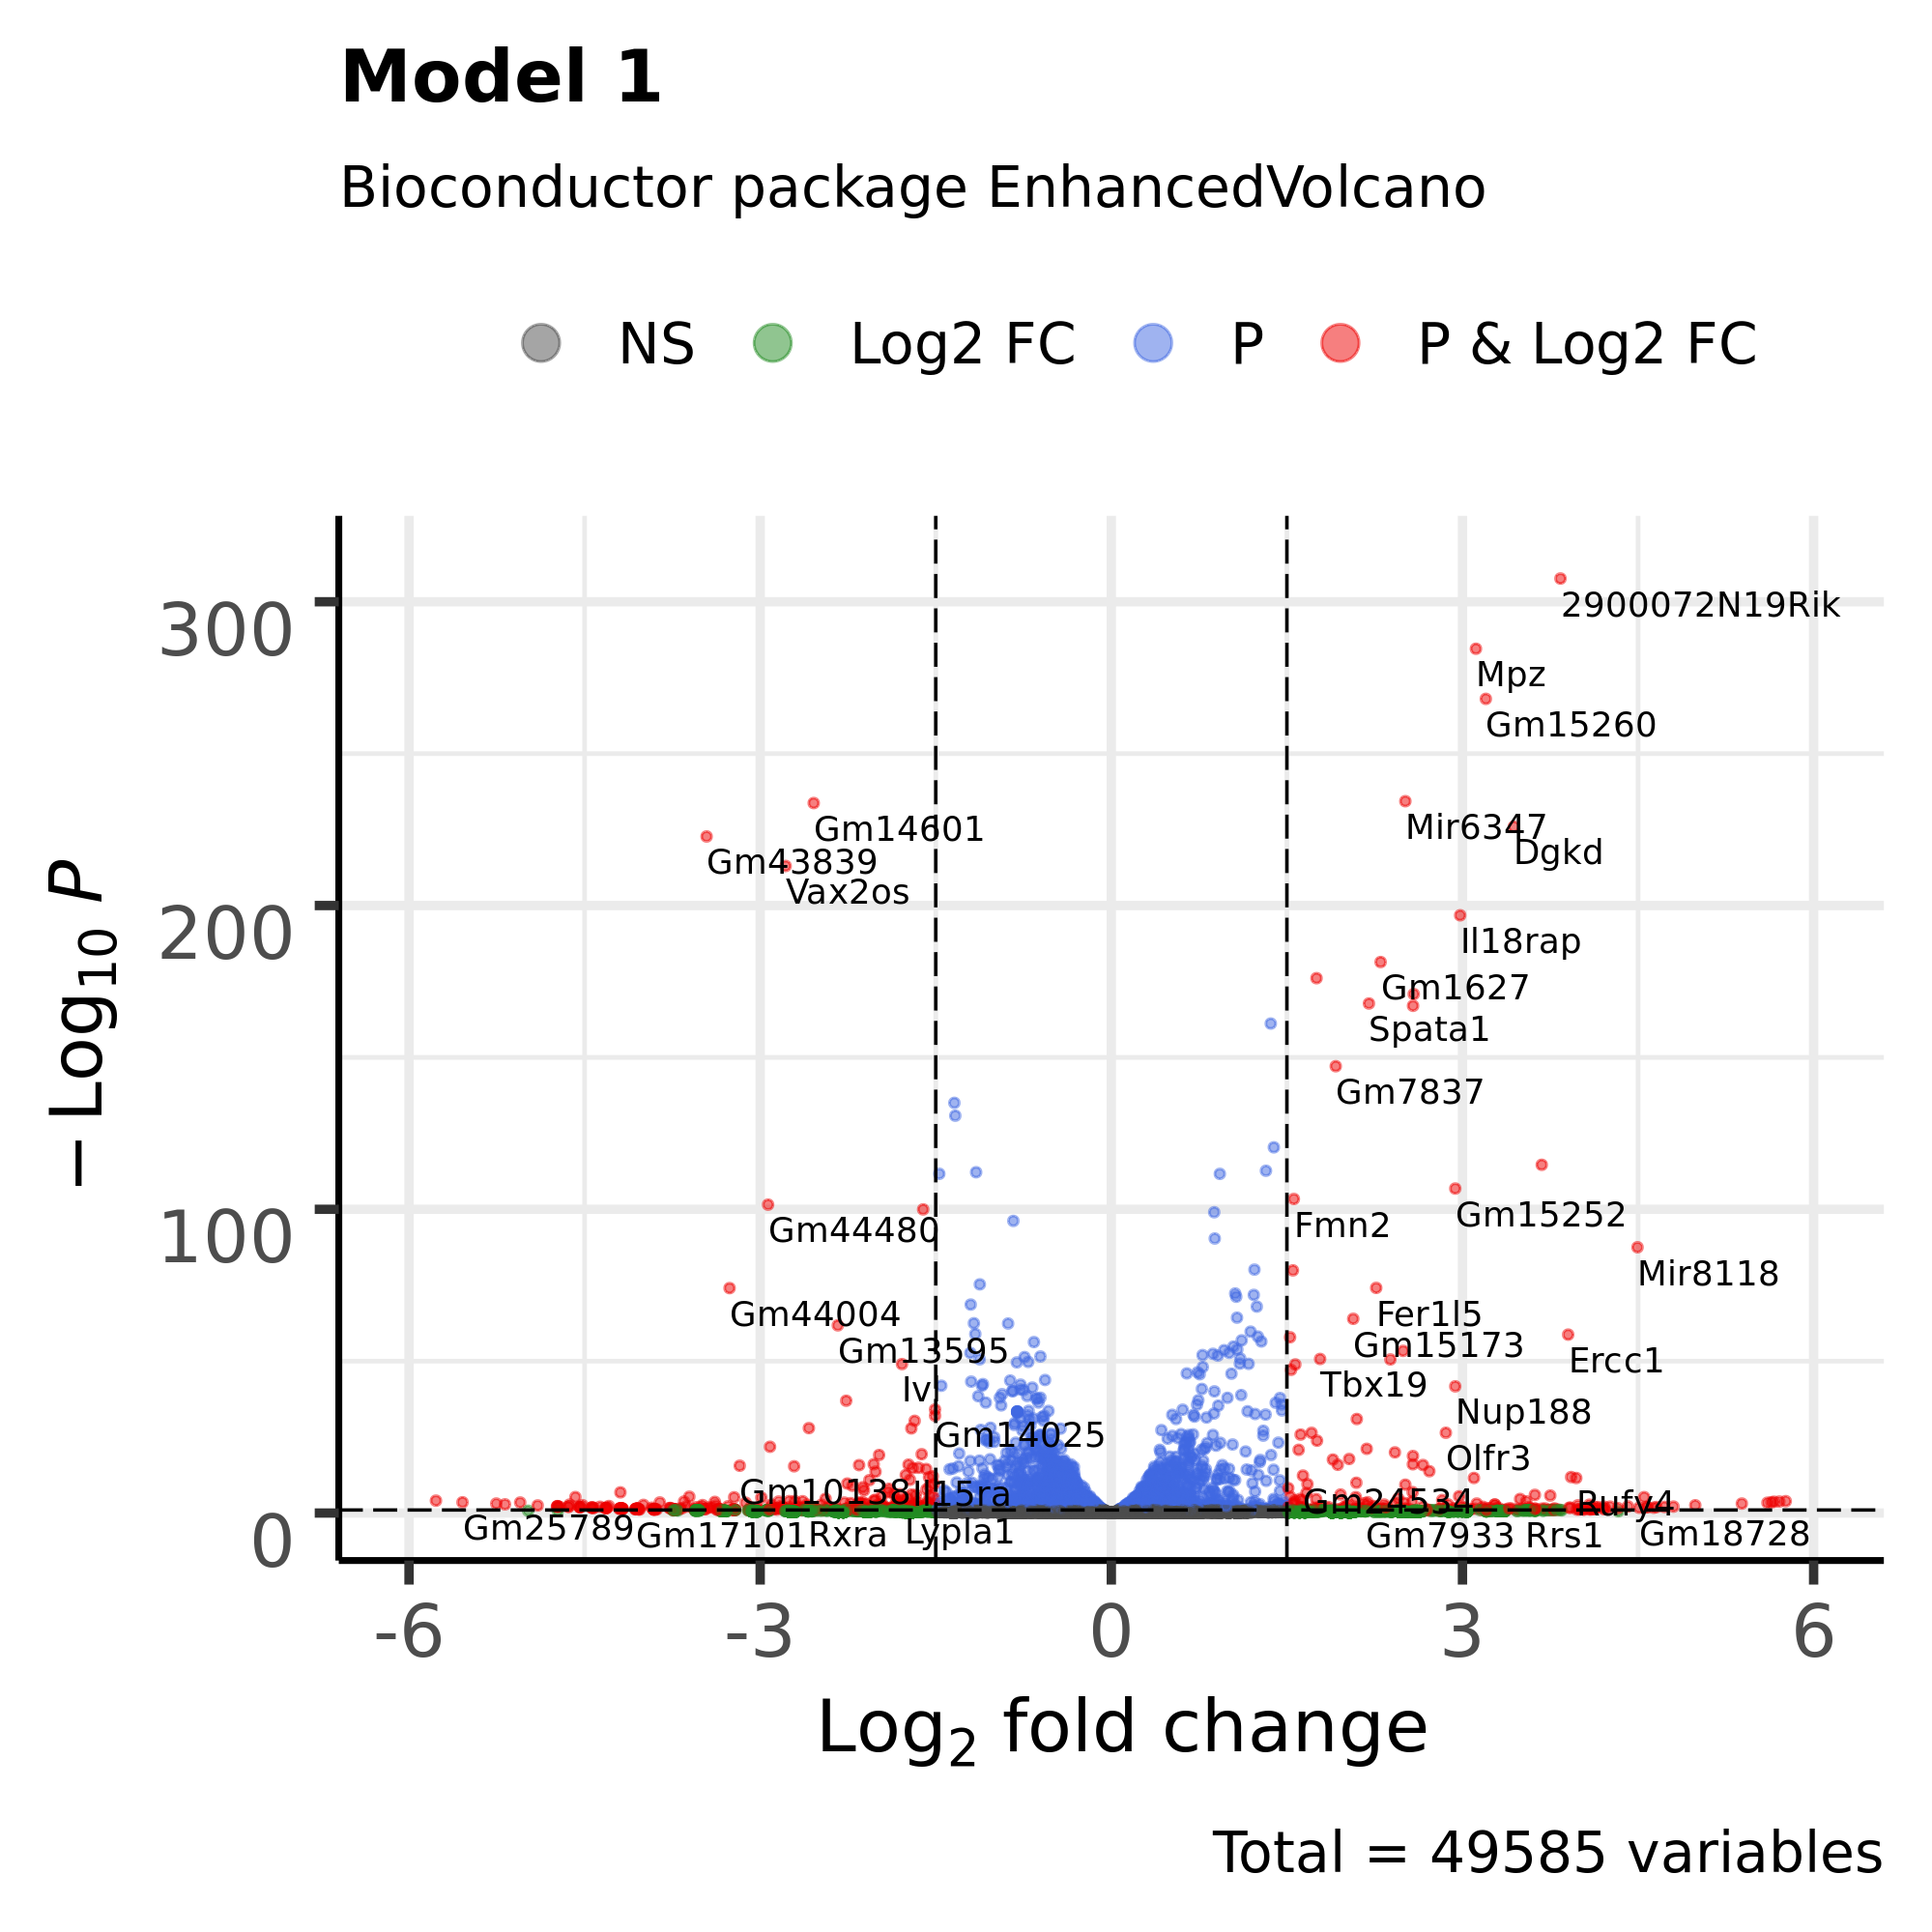

In [176]:
Image("results/plots/model_1_Volcano.png", width=500)

# 2

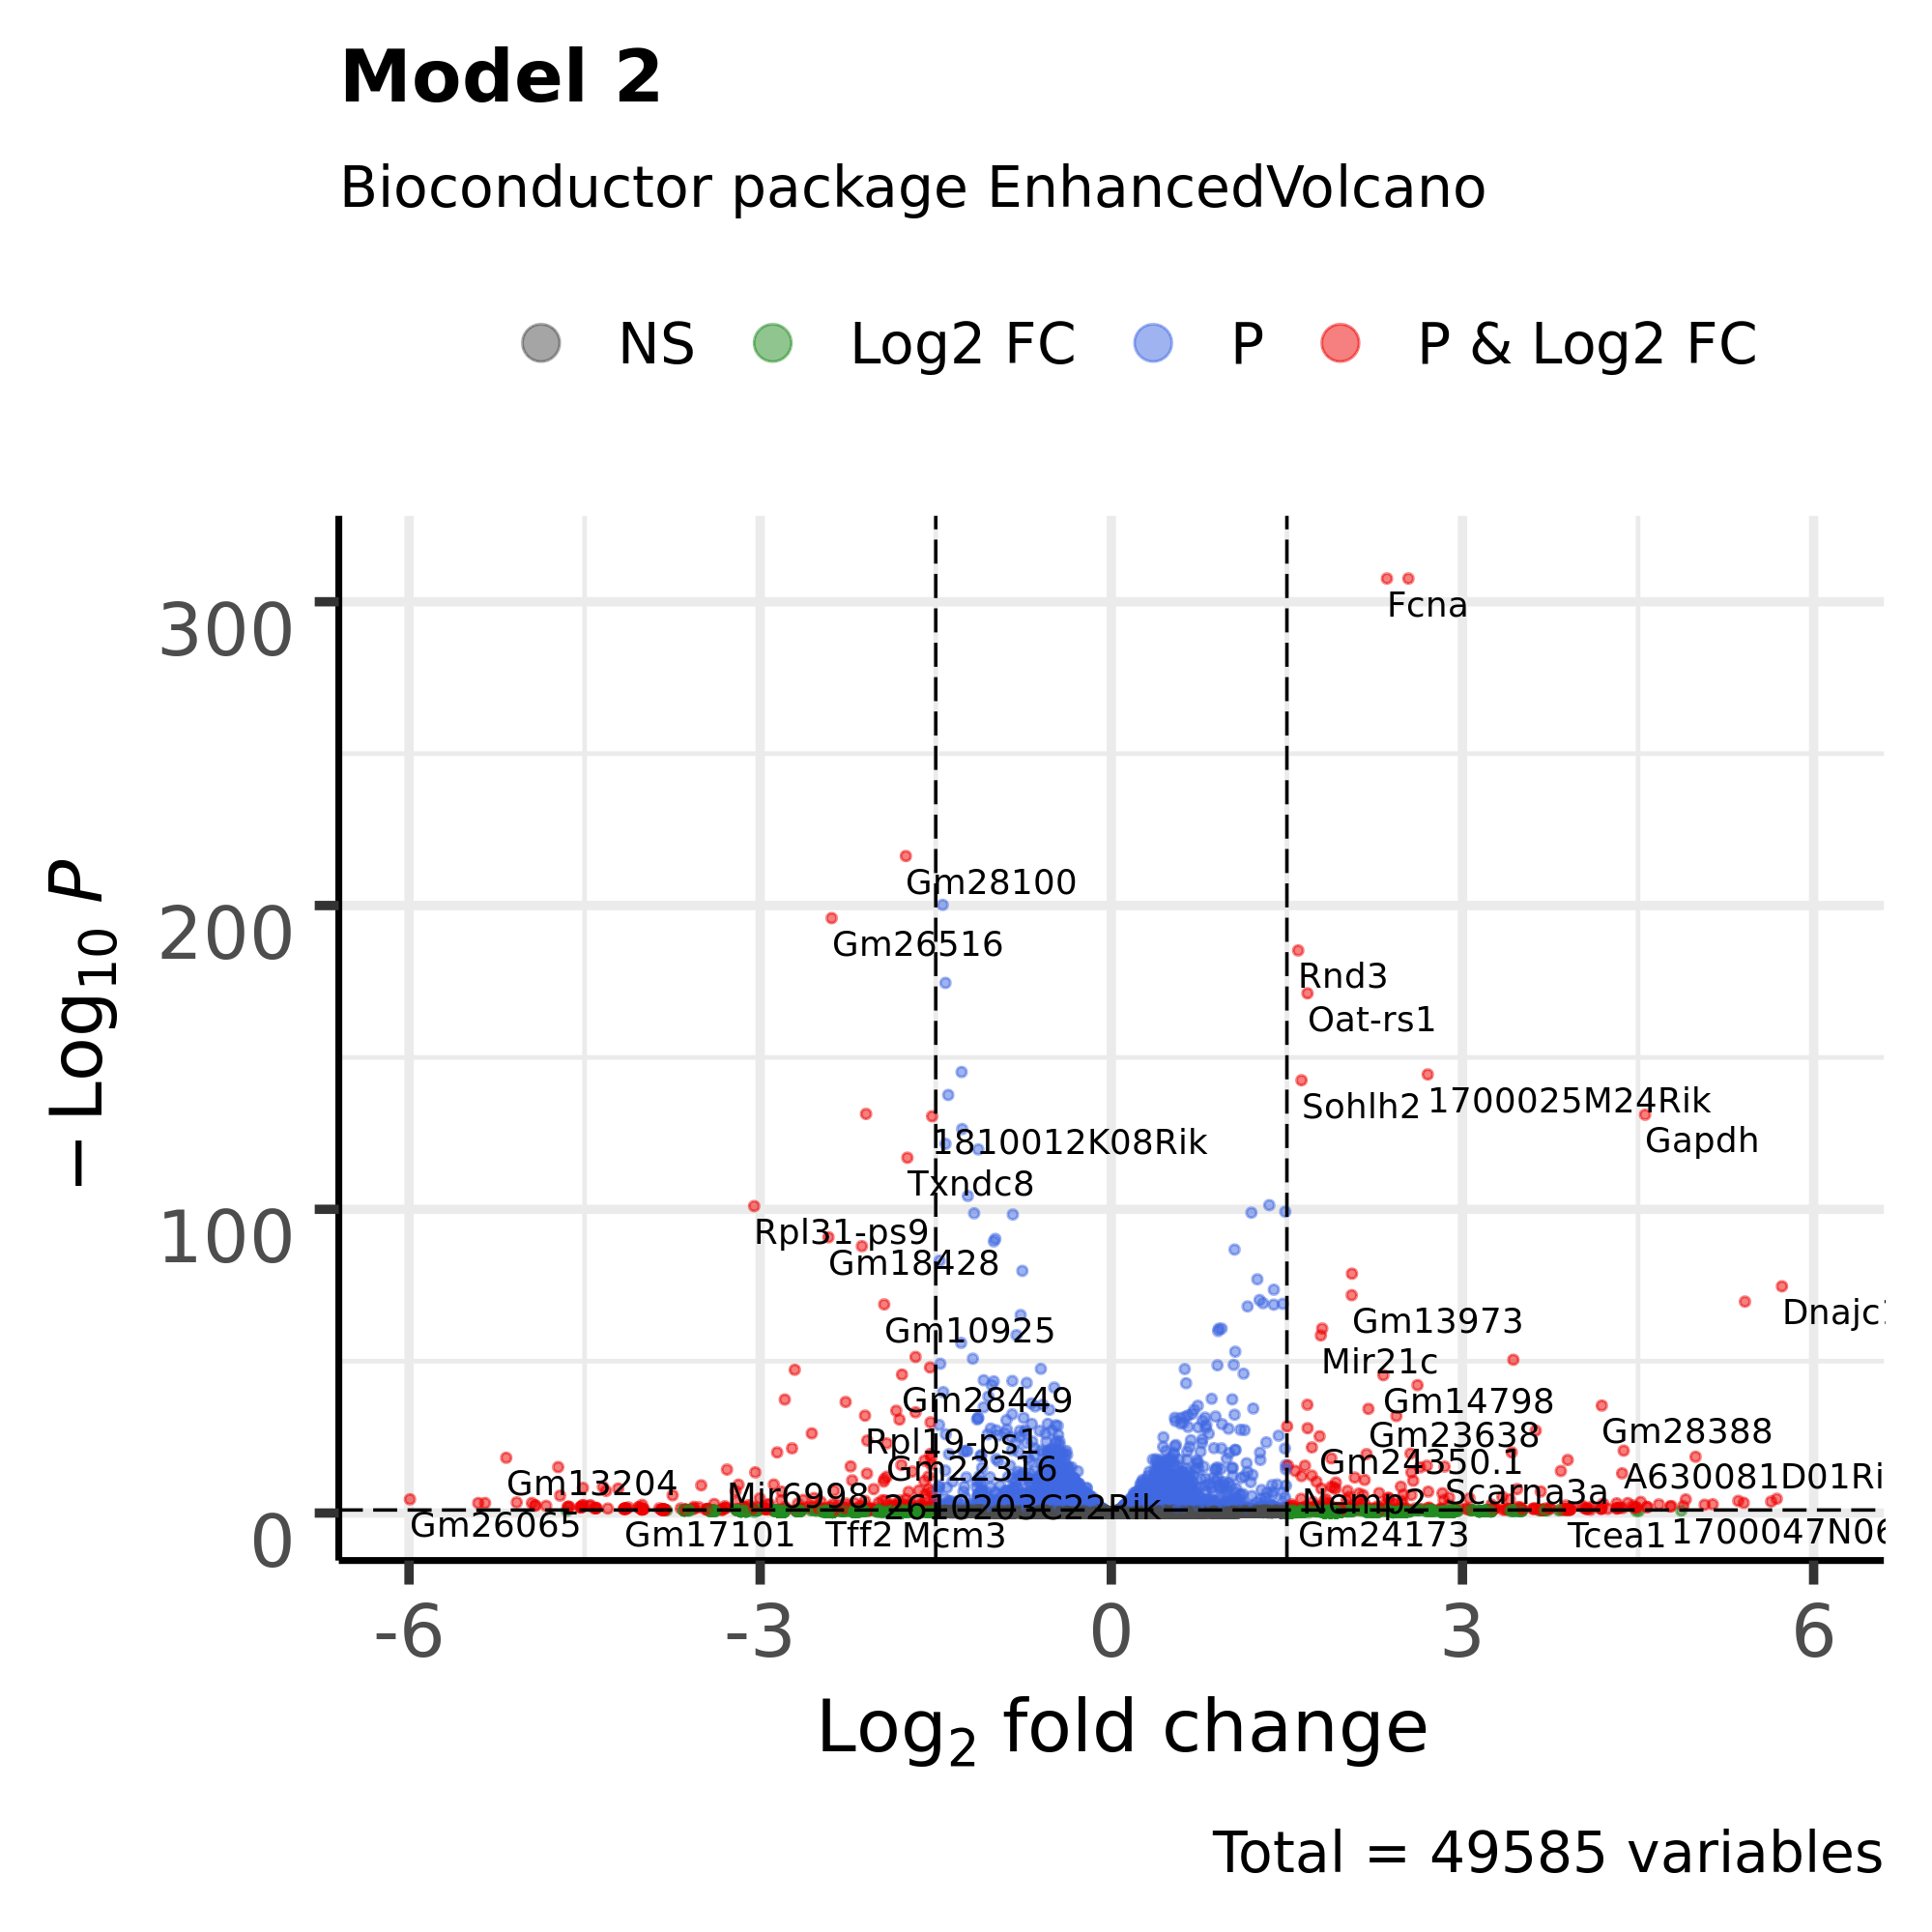

In [177]:
Image("results/plots/model_2_Volcano.png", width=500)

# 3

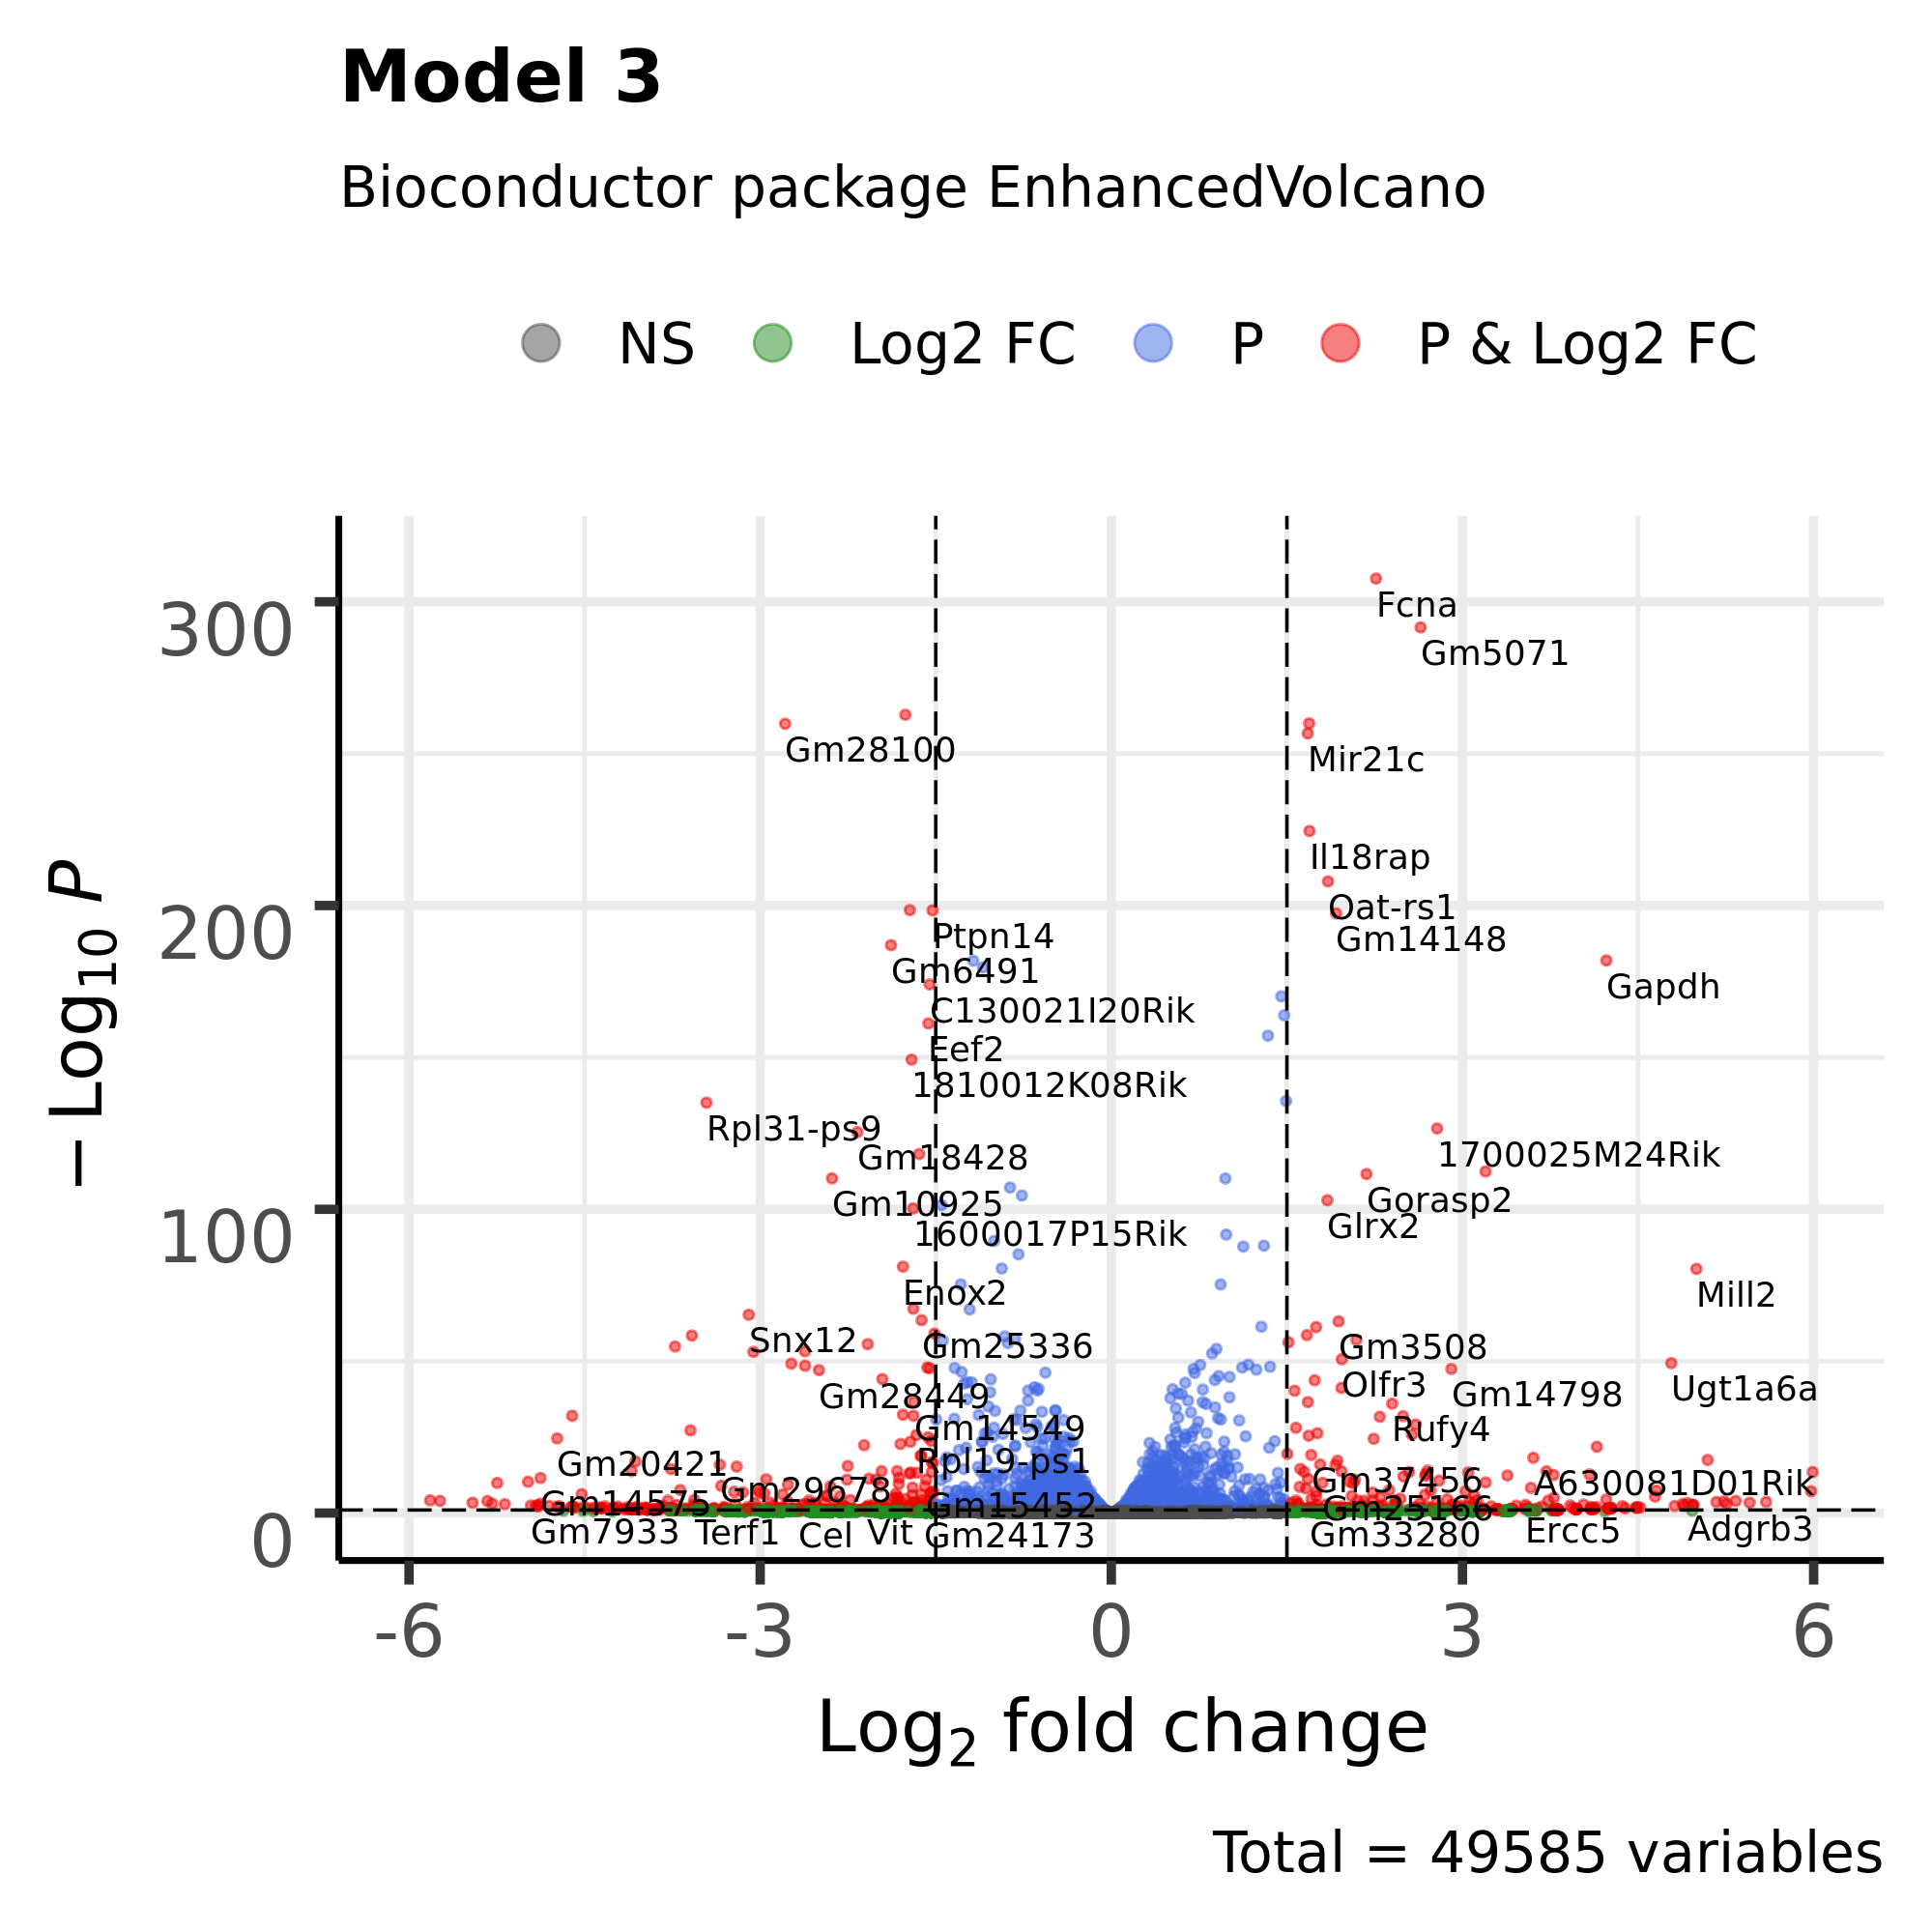

In [178]:
Image("results/plots/model_3_Volcano.png", width=500)

# 4

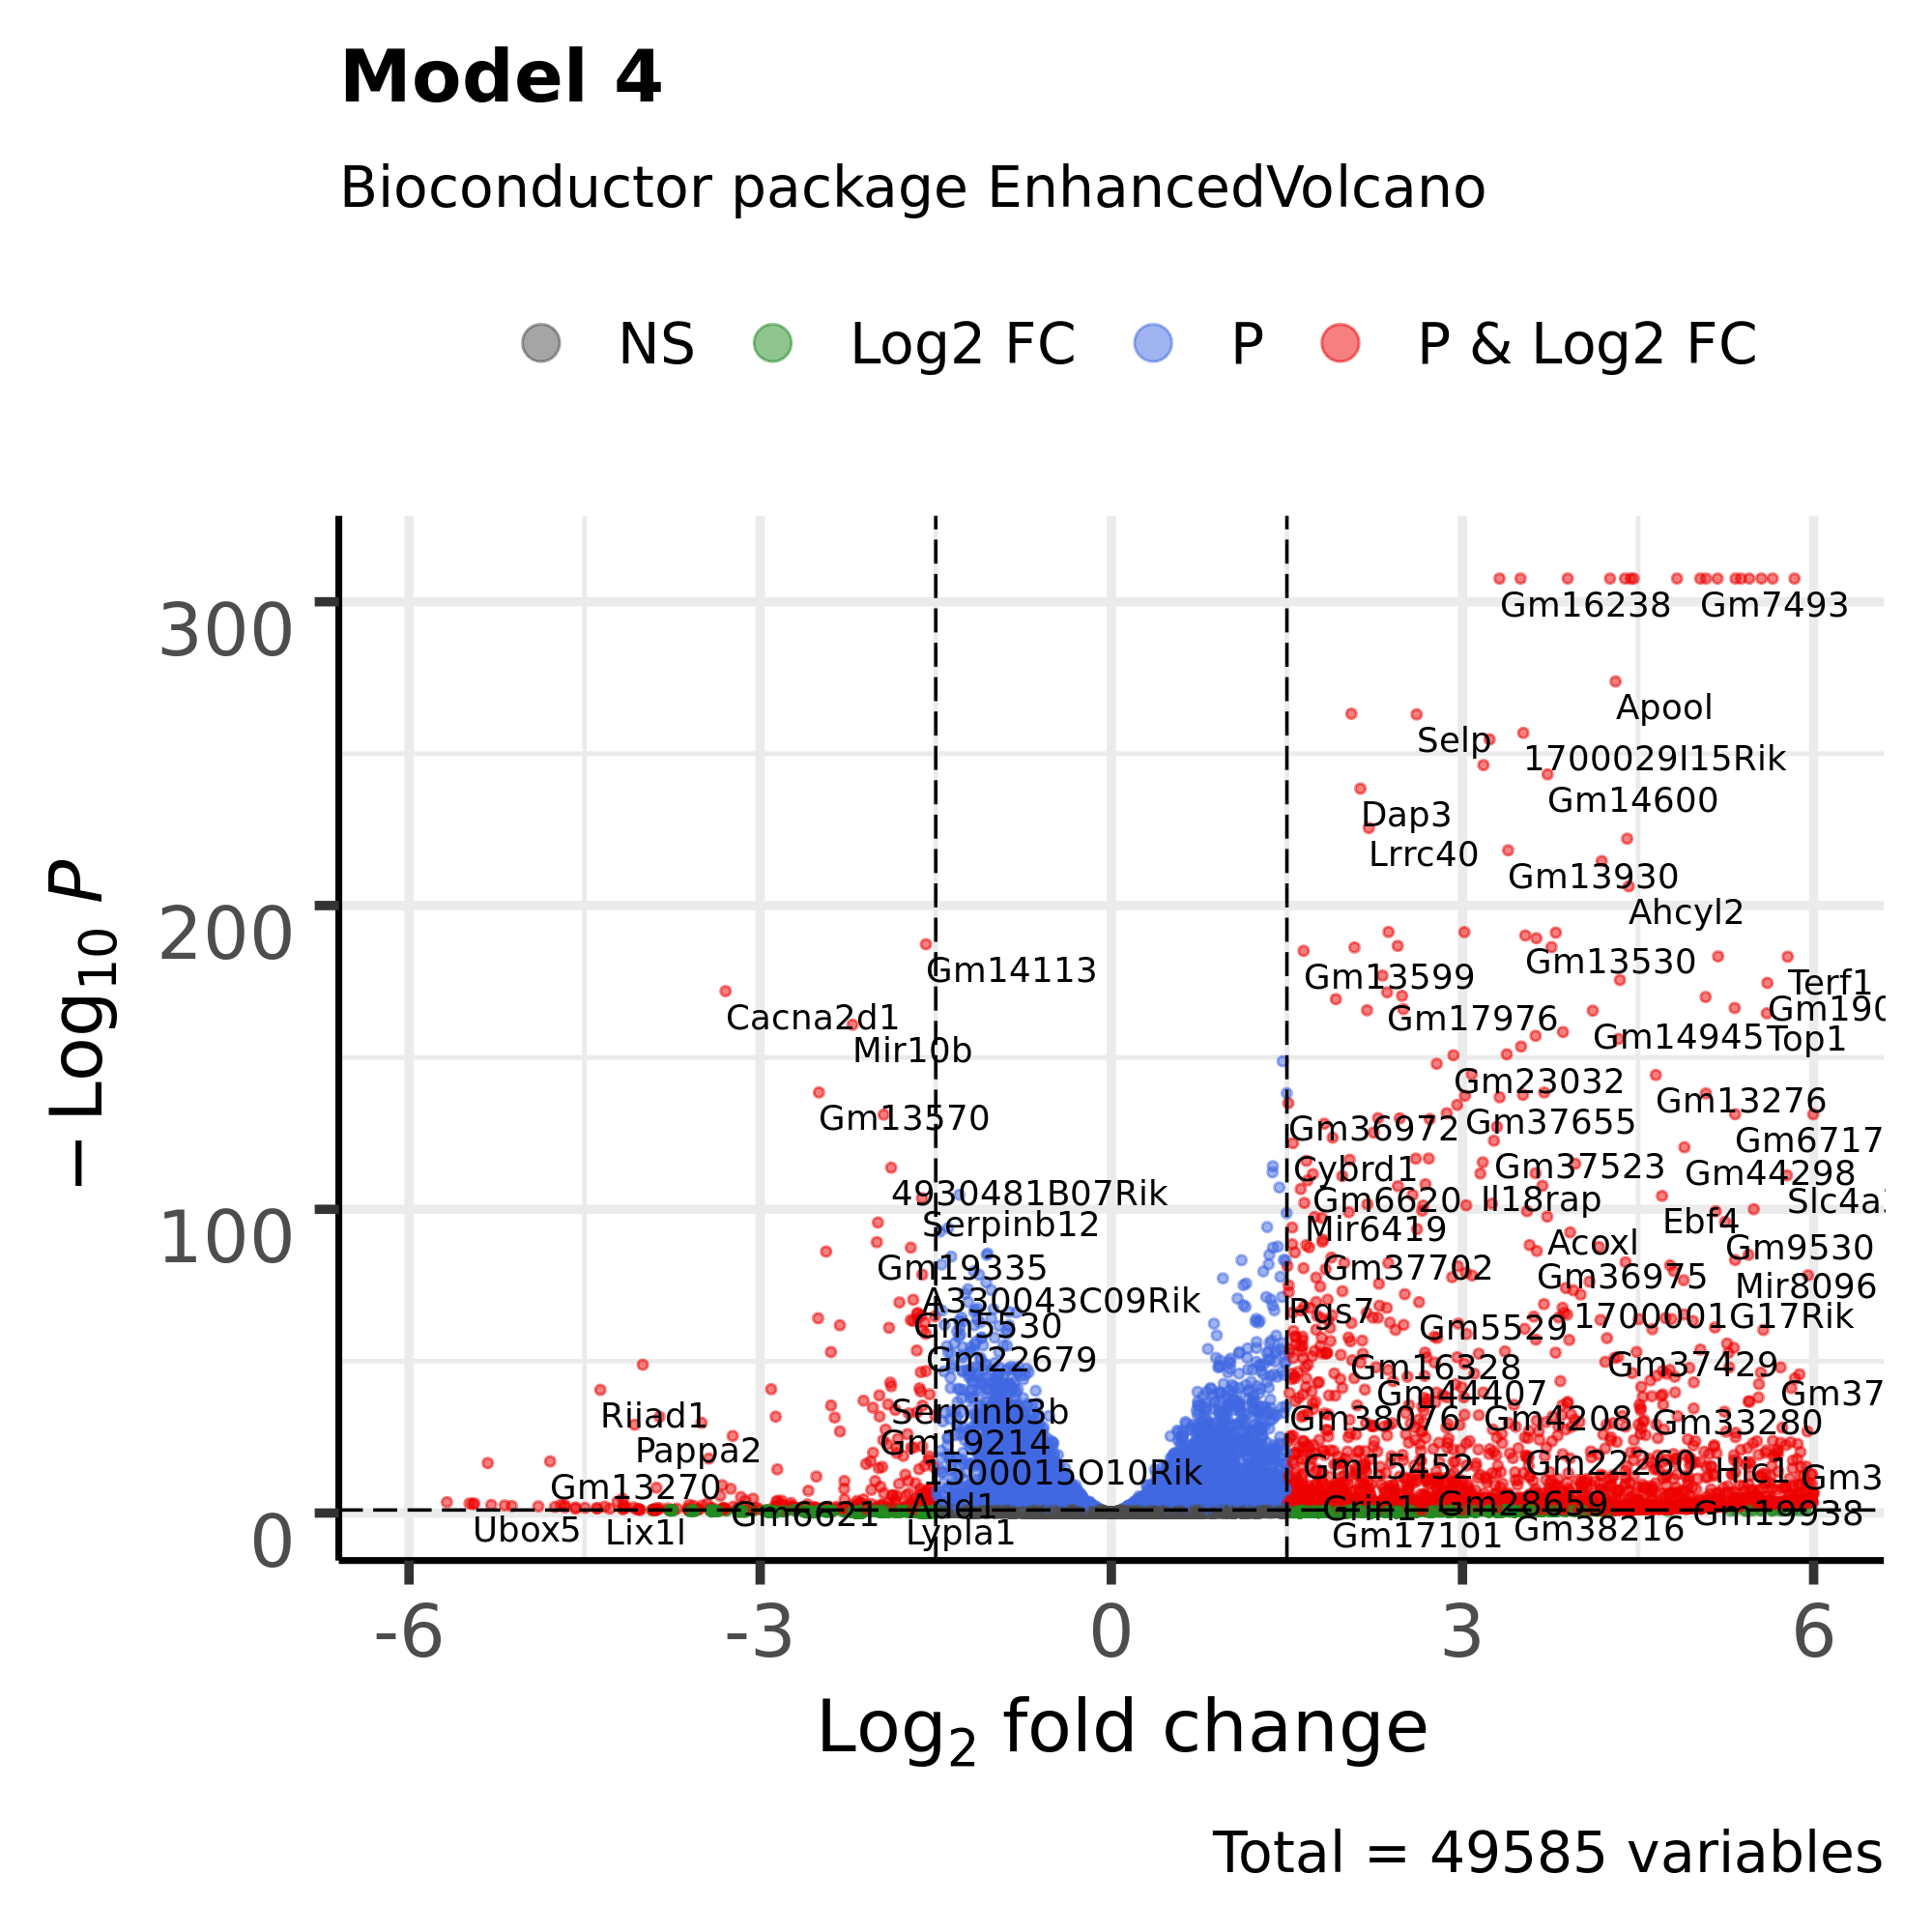

In [179]:
Image("results/plots/model_4_Volcano.png", width=500)

# 5

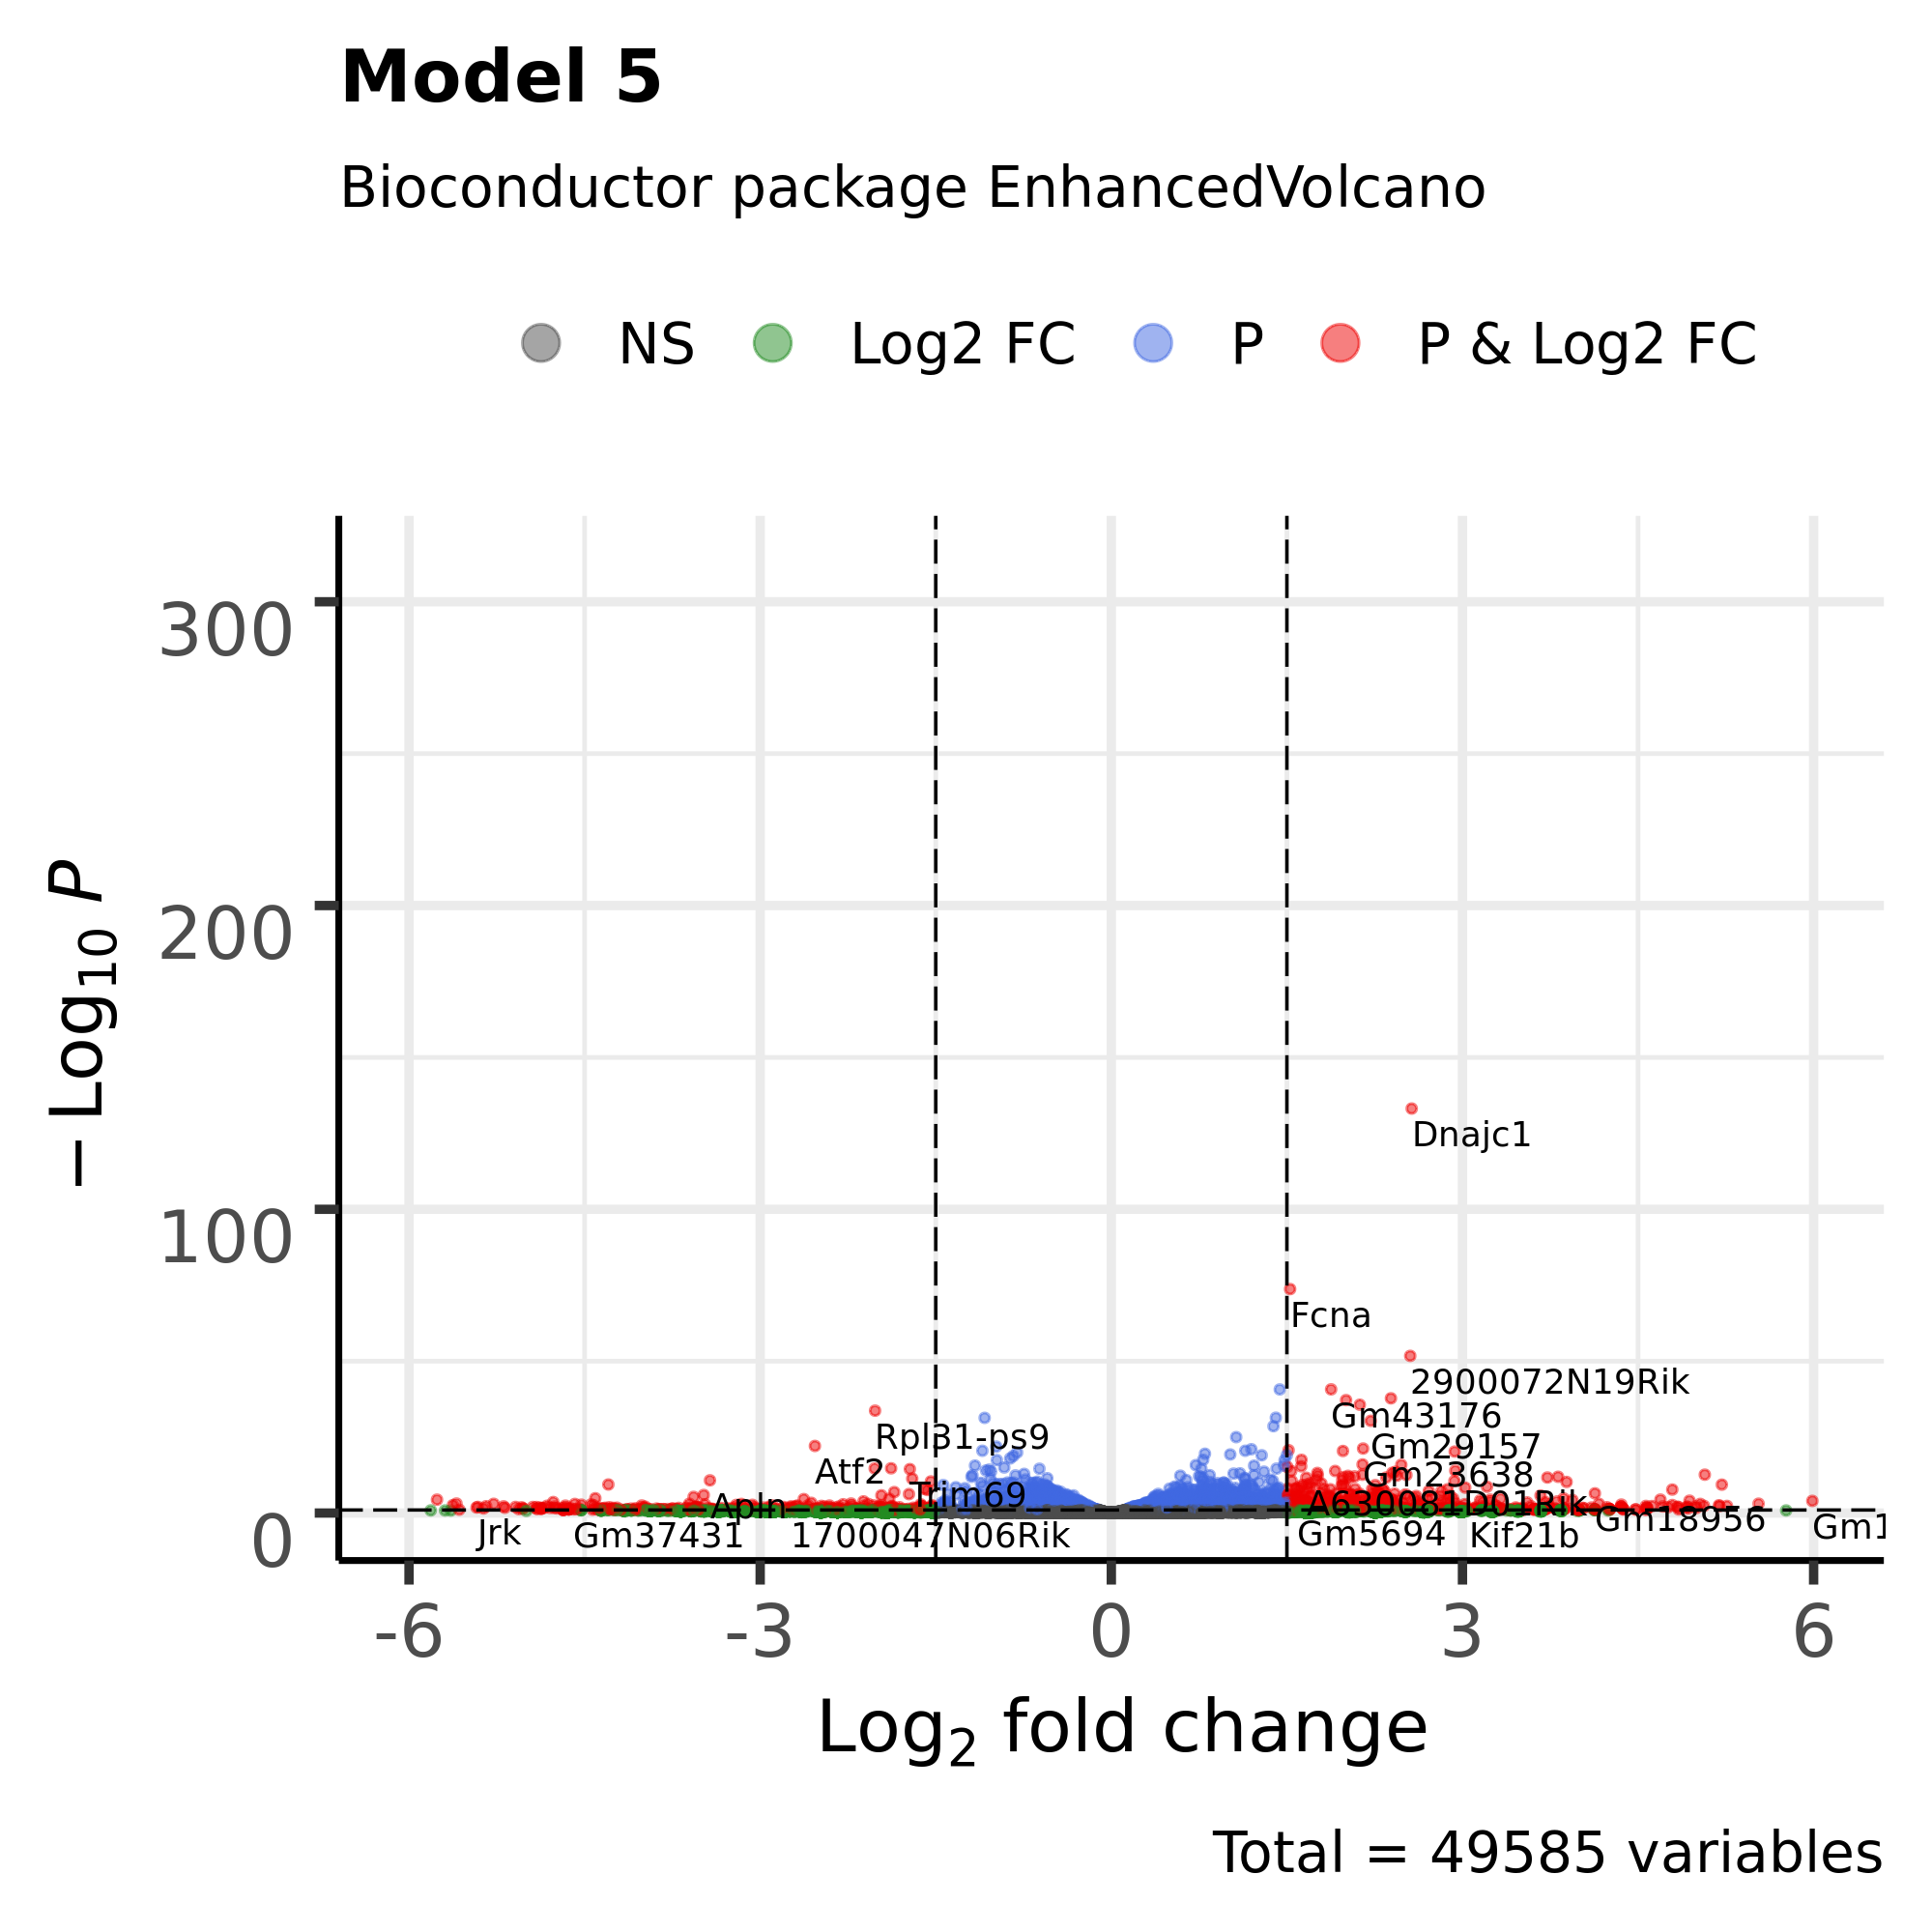

In [180]:
Image("results/plots/model_5_Volcano.png", width=500)